In [76]:
from tqdm.notebook import tqdm_notebook as tqdm
from typing import List, Tuple, Callable
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [77]:
np.random.seed(537314)

# Questão 1

Considere o conjunto de dados disponível em artificial1d.csv organizado em
duas colunas, x e y. Seja um modelo de regressão linear para y^ = f(x).

In [78]:
df = pd.read_csv('artificial1d.csv', header=None, names=['X', 'y'])
df

,X,y
0,-1.000000,-2.082017
1,-0.931034,-1.326980
2,-0.862069,-1.105598
3,-0.793103,-0.873946
4,-0.724138,-0.285027
5,-0.655172,-0.431153
6,-0.586207,-0.794754
7,-0.517241,-0.886068
8,-0.448276,-0.899900
9,-0.379310,-0.861844


In [79]:
X = np.array(df['X'])
y = np.array(df['y'])
# Normalização de X.
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
# Garante que X tenha 2 dimensões.
if X.ndim == 1:
    X = X.reshape(-1, 1)
# X para plotagem.
X_plot = X.flatten()
# Adiciona uma coluna de uns em X.
n: int = len(y)  # Número de entradas.
X = np.hstack((np.ones((n, 1)), X))

In [80]:
def plot_reta(w: np.ndarray, X: np.ndarray, tipo: str) -> None:
    # Cálculo dos valores preditos.
    y_pred = w[0] + w[1] * X
    plt.scatter(X, y, label='Dados reais', color='blue')
    plt.plot(X, y_pred, label='Regressão Linear', color='red')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title(f'Regressão Linear ({tipo})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [81]:
def plot_eqm(erros: List[float]) -> None:
    plt.plot(erros)
    plt.title('EQM ao longo das épocas')
    plt.xlabel('Época')
    plt.ylabel('Erro Quadrático Médio')
    plt.tight_layout()
    plt.show()

a) Apresente os parâmetros do modelo e o MSE (erro quadrático médio)
 obtidos pelo algoritmo OLS (mínimos quadrados ordinários). 
 Plote a reta resultante sobre os dados.

In [82]:
def regressao_linear_ols(X: np.ndarray, y: np.ndarray, lmbda: float = 0) -> Tuple[np.ndarray, float]:
    """
    Implementação da regressão linear pelo método dos mínimos quadrados ordinários (OLS).
    :param X: Matriz de atributos de entrada.
    :param y: Vetor de resultados.
    :param lmbda: Hiperparâmetro da regularização L2.
    :return: Vetor de pesos valor do erro quadrático médio.
    """
    # Está sendo utilizada a pseudoinversa para contornar casos onde X não é invertível.
    pseudoinversa: Callable = np.linalg.pinv
    # Matriz identidade.
    I: np.array = np.eye(X.shape[1])
    # Como o parâmetro w0 não deve ser regularizado, o primeiro elemento será 0.
    I[0][0] = 0
    # Cálculo dos pesos.
    w: np.ndarray = pseudoinversa(X.T @ X + lmbda * I) @ X.T @ y
    y_pred: np.ndarray = X @ w  # Cálculo de y predito.
    e: np.ndarray = y - y_pred  # Cálculo do erro.
    # Cálculo do erro quadrático médio.
    eqm: float = np.mean(e**2) 
    return w, eqm

In [83]:
w, eqm = regressao_linear_ols(X, y)

Parâmetros obtidos:

In [84]:
_ = [print(f'w{i}: {w[i]}') for i in range(len(w))]

w0: 0.06761792463834022
w1: 0.9400795351532126


Erro quadrático médio:

In [85]:
print(eqm)

0.21340090132936987


Reta resultante:

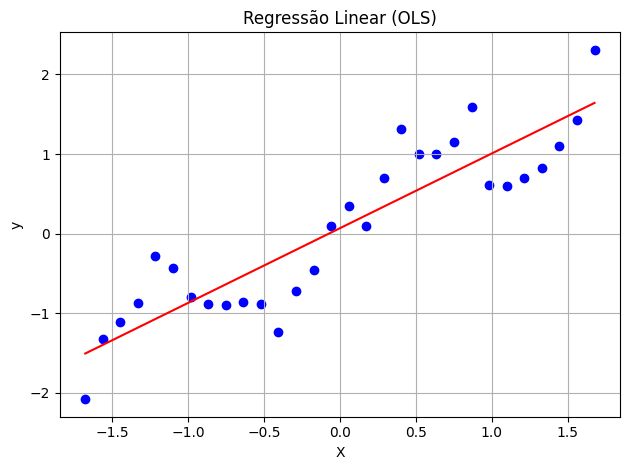

In [86]:
plot_reta(w, X_plot, 'OLS')

b) Apresente os parâmetros do modelo, o MSE e a curva de
aprendizagem obtidos pelo algoritmo GD (gradiente descendente). 
Plote a reta resultante sobre os dados.

In [87]:
def regressao_linear_gd(X: np.ndarray, y: np.ndarray, alpha: float=0.01, epochs: int=1000, 
                        lmbda: float = 0) -> Tuple[np.ndarray, List[float]]:
    """
    Implementação da regressão linear pelo método do gradiente descendente.
    :param X: Matriz de atributos de entrada.
    :param y: Vetor de resultados.
    :param alpha: Taxa de aprendizado do modelo.
    :param epochs: Total de épocas.
    :param lmbda: Hiperparâmetro da regularização L2.
    :return: Vetor de pesos e lista do EQM ao longo das épocas.
    """
    n: int = len(y)  # Número de entradas.
    eqms: List[float] = []  # Erros quadráticos médios.
    # Inicialização dos pesos.
    w: np.ndarray = np.zeros(X.shape[1])
    for _ in range(epochs):
        y_pred: np.ndarray = X @ w  # Cálculo de y predito.
        e: np.ndarray = y - y_pred  # Cálculo do erro.
        # Cálculo do erro quadrático médio.
        eqm: float = np.mean(e**2) 
        eqms.append(eqm)
        # Cálculo da regularização.
        reg: np.array = lmbda * w
        reg[0] = 0  # Removendo w0 da reguralização.
        # Atualização dos parâmetros.
        w = w + alpha * (1/n * (X.T @ e) - reg)
    return w, eqms

In [88]:
w, erros = regressao_linear_gd(X, y)

Parâmetros obtidos:

In [89]:
_ = [print(f'w{i}: {w[i]}') for i in range(len(w))]

w0: 0.06761500548818634
w1: 0.9400389507470148


Erro quadrático médio:

In [90]:
print(erros[-1])

0.213400903018601


Curva de aprendizagem:

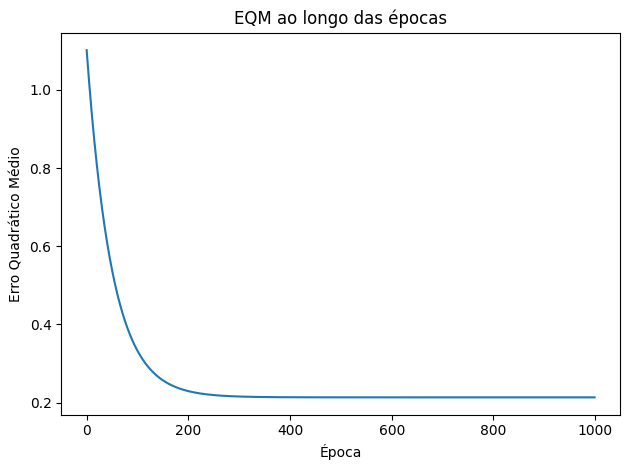

In [91]:
plot_eqm(erros)

Reta resultante:

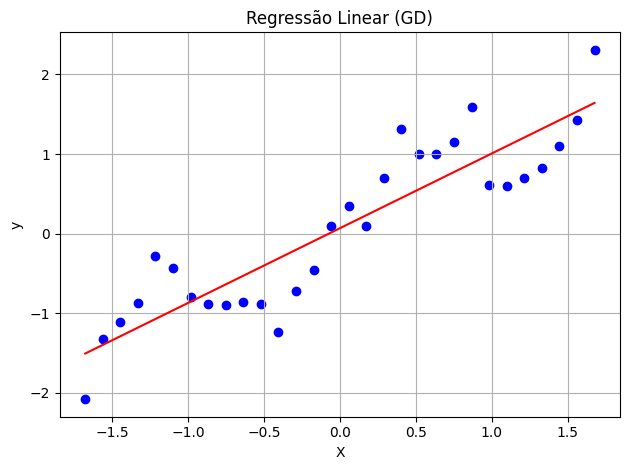

In [92]:
plot_reta(w, X_plot, 'GD')

c) Apresente os parâmetros do modelo, o MSE e a curva de aprendizagem
obtidos pelo algoritmo SGD (gradiente descendente estocástico).
Plote a reta resultante sobre os dados.

In [93]:
def regressao_linear_gde(X: np.ndarray, y: np.ndarray, alpha: float=0.003, epochs: int=100, 
                         lmbda: float = 0) -> Tuple[np.ndarray, List[float]]:
    """
    Implementação da regressão linear pelo método do gradiente descendente estocástico.
    :param X: Matriz de atributos de entrada.
    :param y: Vetor de resultados.
    :param alpha: Taxa de aprendizado do modelo.
    :param epochs: Total de épocas.
    :param lmbda: Hiperparâmetro da reguralização L2.
    :return: Vetor de pesos e lista do EQM ao longo das épocas.
    """
    n: int = len(y)  # Número de entradas.
    eqms: List[float] = []  # Erros quadráticos médios.
    # Inicialização dos pesos.
    w: np.ndarray = np.zeros(X.shape[1])
    for epoch in range(epochs):
        idx = np.random.permutation(n)
        # Embaralhamento de X e y.
        X = X[idx]
        y = y[idx]
        for xi, yi in zip(X, y):
            y_i_pred: np.ndarray = xi @ w  # Cálculo de yi predito.
            e_i: np.ndarray = yi - y_i_pred  # Cálculo do erro.
            # Cálculo da regularização.
            reg: np.array = lmbda * w
            reg[0] = 0  # Removendo w0 da reguralização.
            # Atualização dos parâmetros.
            w += alpha * (xi * e_i - reg)
        # Cálculo do erro quadrático médio.            
        y_pred: np.ndarray = X @ w  # Cálculo de y predito.
        e: np.ndarray = y - y_pred  # Cálculo do erro.
        eqm: float = np.mean(e**2) 
        eqms.append(eqm)
    return w, eqms

In [94]:
w, erros = regressao_linear_gde(X, y)

Parâmetros obtidos:

In [95]:
_ = [print(f'w{i}: {w[i]}') for i in range(len(w))]

w0: 0.06695683112831916
w1: 0.9396655444663875


Erro quadrático médio:

In [96]:
print(erros[-1])

0.2134015097622877


Curva de aprendizagem:

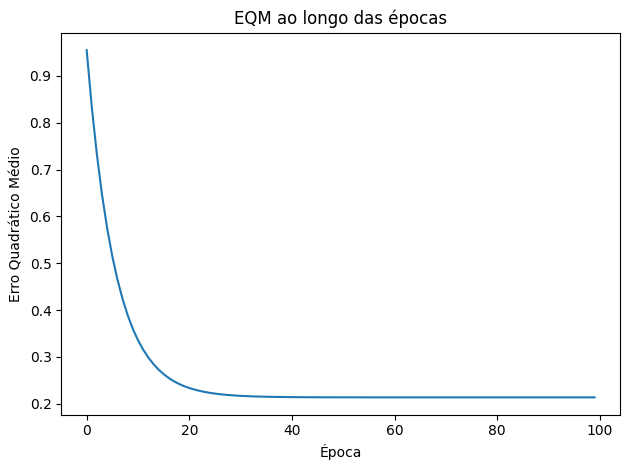

In [97]:
plot_eqm(erros)

Reta resultante:

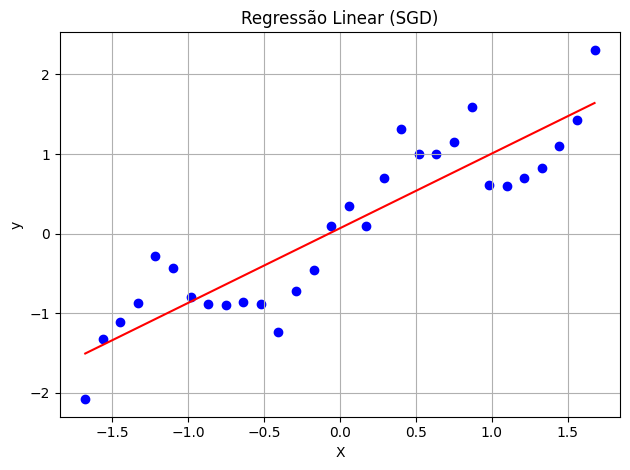

In [98]:
plot_reta(w, X_plot, 'SGD')

# Questão 2
Considere o conjunto de dados disponível em california.csv, organizado em 9
colunas, sendo as 8 primeiras colunas os atributos e a última coluna a saída.
Os 8 atributos são usados na predição da mediana de preços de casas em dis
tritos da Califórnia na década de 1990. Maiores detalhes sobre os dados po
dem ser conferidos em https://scikit-learn.org/stable/datasets/real_
world.html#california-housing-dataset.

In [99]:
names = [f'X{i}' for i in range(1, 9)] + ['y']
df = pd.read_csv('california.csv', header=None, names=names)
df

,X1,X2,X3,X4,X5,X6,X7,X8,y
0,4.1685,20.0,6.700637,1.178344,745.0,2.372611,38.80,-121.15,2.175
1,2.8194,24.0,4.762500,1.020833,608.0,2.533333,36.75,-119.85,0.811
2,2.4250,46.0,4.927711,1.018072,772.0,2.325301,36.33,-119.31,0.849
3,3.1205,16.0,3.728477,1.101545,1260.0,2.781457,33.87,-117.99,1.740
4,4.3889,41.0,5.741007,1.199041,837.0,2.007194,34.15,-118.40,3.804
...,...,...,...,...,...,...,...,...,...
995,4.6076,6.0,4.665773,1.087578,2597.0,2.320822,33.66,-117.64,2.040
996,5.1909,16.0,6.671779,1.003067,1037.0,3.180982,32.99,-117.09,2.014
997,4.7308,35.0,5.666667,0.971831,601.0,2.821596,33.83,-118.37,3.534
998,4.2788,10.0,5.375000,1.114583,282.0,2.937500,33.68,-117.35,1.250


In [100]:
X = np.array(df[[f'X{i}' for i in range(1, 9)]])
y = np.array(df['y'])
# Normalização de X.
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
# Adiciona uma coluna de uns em X.
n: int = len(y)  # Número de entradas.
X = np.hstack((np.ones((n, 1)), X))

a) Aleatoriamente, divida o conjunto de dados em treino (80%) e teste (20%).

In [101]:
n: int = len(y)  # Número de entradas.
idx = np.random.permutation(n)
# Embaralhamento de X e y.
X = X[idx]
y = y[idx]
# Cálculo do índice separador.
sep = int(len(X) * 0.2)
X_train, X_test = X[sep:], X[:sep]
y_train, y_test = y[sep:], y[:sep]

b) Treine 13 modelos de regressão polinomial, com ordens de 1 a 13. 
Você pode usar o algoritmo OLS.

In [102]:
def adiciona_potencias(X: np.ndarray, grau: int) -> np.ndarray:
    """
    Retorna um vetor com as colunas de X elevadas a todas as potências de 1 até o grau.
    :param X: Vetor original.
    :param grau: Grau máximo das potências.
    :return: Novo vetor com as novas colunas.
    """
    concatena: Callable = np.column_stack
    new_X = X.copy()  # Cria uma cópia de X.
    # Concatena as potências de X.
    for i in range(2, grau+1):
        new_X = concatena((new_X, X**i))
    return new_X

In [103]:
def regressao_polinomial(X: np.ndarray, y: np.ndarray, grau: int = 1, algoritmo: str = 'OLS', 
                         alpha: float=0.01, epochs: int=1000, lmbda: float = 0) -> Tuple[np.ndarray, float]:
    """
    Implementação da regressão polinomial, que cria polinômios até certo grau para gerar mais informação ao modelo.
    :param X: Matriz de atributos de entrada.
    :param y: Vetor de resultados.
    :param grau: Grau máximo para as potências.
    :param algoritmo: Algoritmo a ser utilizado para cálculo dos pesos. Pode ser 'OLS', 'GD' ou 'GDE'.
    :param alpha: Taxa de aprendizado do modelo.
    :param epochs: Total de épocas.
    :param lmbda: Hiperparâmetro da reguralização L2.
    :return: Vetor de pesos e o RMSE.
    """
    # Adiciona as potência a X.
    new_X = adiciona_potencias(X, grau)
    # Em cada caso, recebe o vetor de pesos e o eqm e calcula o RMSE.
    # No caso do GD e GDE, é necessário acessar o último eqm.
    if algoritmo == 'OLS':
        w, eqm = regressao_linear_ols(new_X, y, lmbda)
        return w, eqm**0.5
    elif algoritmo == 'GD':
        w, eqms = regressao_linear_gd(new_X, y, alpha, epochs, lmbda)
        return w, (eqms[-1])**0.5
    elif algoritmo == 'GDE':
        w, eqms = regressao_linear_gde(new_X, y, alpha, epochs, lmbda)
        return w, (eqms[-1])**0.5
    else:
        raise ValueError(f'Algoritmo [{algoritmo}] não implementado.')

In [104]:
algoritmo = 'OLS' 
graus = 13
ws: List[np.array] = []  # Lista de arrays de pesos.
rmses_train: List[List[float]|float] = []  # Lista dos eqm.
for grau in tqdm(range(1, graus+1)):
    w, rmse = regressao_polinomial(X_train, y_train, grau, algoritmo)
    ws.append(w)
    rmses_train.append(rmse)

  0%|          | 0/13 [00:00<?, ?it/s]

c) Reporte o RMSE(raiz quadrada do erro quadrático 
médio) no treinamento e no teste para cada modelo. 
Faça um gráfico para o treino e um gráfico para o teste.

In [105]:
rmses_test: List[float] = []
for grau in range(graus):
    # Acessando os pesos do grau.
    w: np.array = ws[grau]
    # Acessando o RMSE do treino do grau.
    rmse_train: float = rmses_train[grau]
    # Gera um X de teste com as potências de grau+1, pois grau está começando em 0 neste caso.
    new_X_test = adiciona_potencias(X_test, grau+1)
    # Cálculo do eqm do teste.           
    y_pred: np.ndarray = new_X_test @ w  # Cálculo de y predito.
    e: np.ndarray = y_test - y_pred  # Cálculo do erro.
    eqm_test: float = np.mean(e**2)
    # Cálculo do RMSE de teste.
    rmse_test = eqm_test**0.5
    rmses_test.append(rmse_test)
    
    print(f'Grau: {grau+1}')
    print(f'RMSE treino: {rmse_train}')
    print(f'RMSE teste:  {rmse_test}\n')    

Grau: 1
RMSE treino: 0.6753768690152859
RMSE teste:  0.666634679937769

Grau: 2
RMSE treino: 0.6535403637063106
RMSE teste:  0.6732128974778423

Grau: 3
RMSE treino: 0.6266522074397267
RMSE teste:  1.2776489707174696

Grau: 4
RMSE treino: 0.6171174220034353
RMSE teste:  0.8814935057980332

Grau: 5
RMSE treino: 0.60753095383211
RMSE teste:  5.434855479032958

Grau: 6
RMSE treino: 0.5984629904167474
RMSE teste:  40.543327352462704

Grau: 7
RMSE treino: 0.8062025137887293
RMSE teste:  72.88932597075286

Grau: 8
RMSE treino: 2.0154493589291813
RMSE teste:  368.9715135152917

Grau: 9
RMSE treino: 2.314917755948754
RMSE teste:  483.8207639319117

Grau: 10
RMSE treino: 2.3220813421618822
RMSE teste:  75.01395042410613

Grau: 11
RMSE treino: 2.3572465234351334
RMSE teste:  149.02014164994574

Grau: 12
RMSE treino: 2.360144922323886
RMSE teste:  241.43240866864784

Grau: 13
RMSE treino: 2.3621187721848185
RMSE teste:  128.91309156714684


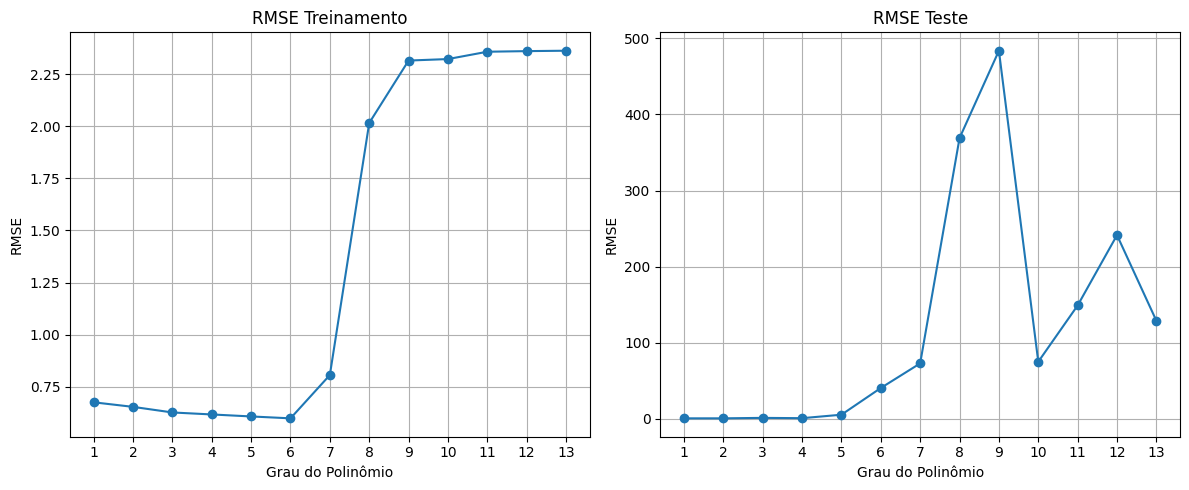

In [106]:
x_ticks = list(range(1, graus+1)) 

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 linha, 2 colunas

axs[0].plot(x_ticks, rmses_train, marker='o')
axs[0].set_title('RMSE Treinamento')
axs[0].set_xlabel('Grau do Polinômio')
axs[0].set_ylabel('RMSE')
axs[0].set_xticks(x_ticks)
axs[0].grid(True)

axs[1].plot(x_ticks, rmses_test, marker='o')
axs[1].set_title('RMSE Teste')
axs[1].set_xlabel('Grau do Polinômio')
axs[1].set_ylabel('RMSE')
axs[1].set_xticks(x_ticks)
axs[1].grid(True)

plt.tight_layout()
plt.show()

d) Repita os 2 itens anteriores incluindo um termo 
de regularização L2 (por exemplo, com fator λ = 0.01).

Treine 13 modelos de regressão polinomial, com ordens de 1 a 13. 

In [107]:
algoritmo = 'OLS' 
graus = 13
lmbda = 0.01
ws: List[np.array] = []  # Lista de arrays de pesos.
rmses_train: List[List[float]|float] = []  # Lista dos eqm.
for grau in tqdm(range(1, graus+1)):
    w, rmse = regressao_polinomial(X_train, y_train, grau, algoritmo, lmbda=lmbda)
    ws.append(w)
    rmses_train.append(rmse)

  0%|          | 0/13 [00:00<?, ?it/s]

Reporte o RMSE(raiz quadrada do erro quadrático 
médio) no treinamento e no teste para cada modelo. 
Faça um gráfico para o treino e um gráfico para o teste.

In [108]:
rmses_test: List[float] = []
for grau in range(graus):
    # Acessando os pesos do grau.
    w: np.array = ws[grau]
    # Acessando o RMSE do treino do grau.
    rmse_train: float = rmses_train[grau]
    # Gera um X de teste com as potências de grau+1, pois grau está começando em 0 neste caso.
    new_X_test = adiciona_potencias(X_test, grau+1)
    # Cálculo do eqm do teste.           
    y_pred: np.ndarray = new_X_test @ w  # Cálculo de y predito.
    e: np.ndarray = y_test - y_pred  # Cálculo do erro.
    eqm_test: float = np.mean(e**2)
    # Cálculo do RMSE de teste.
    rmse_test = eqm_test**0.5
    rmses_test.append(rmse_test)
    
    print(f'Grau: {grau+1}')
    print(f'RMSE treino: {rmse_train}')
    print(f'RMSE teste:  {rmse_test}\n')    

Grau: 1
RMSE treino: 0.6753768721612556
RMSE teste:  0.6666407438424616

Grau: 2
RMSE treino: 0.6535403683140643
RMSE teste:  0.6732255850431131

Grau: 3
RMSE treino: 0.6266522193021244
RMSE teste:  1.2775298970270936

Grau: 4
RMSE treino: 0.6171174383513843
RMSE teste:  0.881466840626146

Grau: 5
RMSE treino: 0.607530964714539
RMSE teste:  5.4343449113829605

Grau: 6
RMSE treino: 0.5984610918605121
RMSE teste:  40.524692776942864

Grau: 7
RMSE treino: 0.8062019186793145
RMSE teste:  72.89441218485484

Grau: 8
RMSE treino: 2.015449359013259
RMSE teste:  368.97150749785953

Grau: 9
RMSE treino: 2.314917755948753
RMSE teste:  483.82076384398874

Grau: 10
RMSE treino: 2.3220813421618822
RMSE teste:  75.0139504239788

Grau: 11
RMSE treino: 2.3572465234351334
RMSE teste:  149.02014164994054

Grau: 12
RMSE treino: 2.360144922323886
RMSE teste:  241.43240866864784

Grau: 13
RMSE treino: 2.3621187721848185
RMSE teste:  128.91309156714684


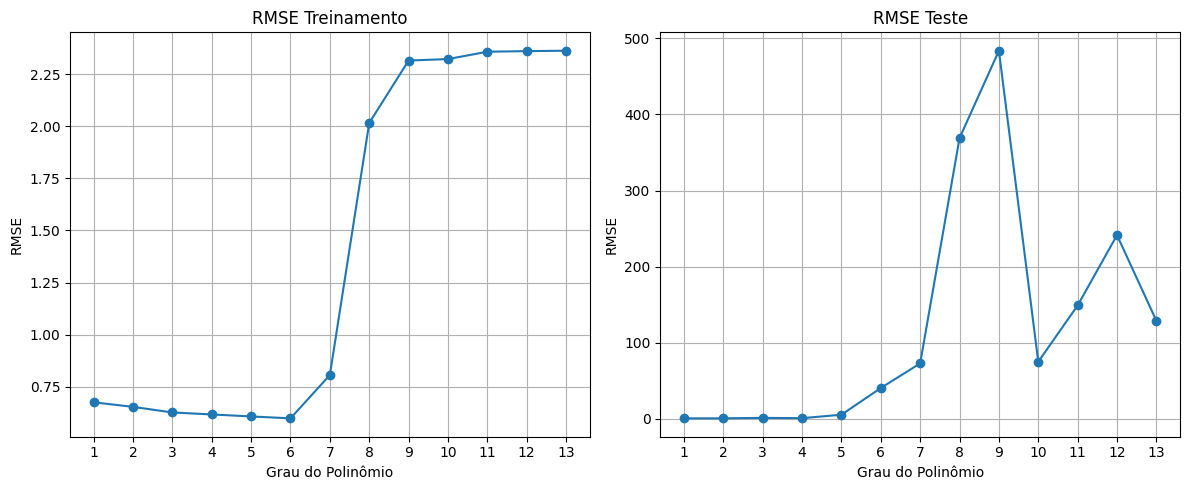

In [109]:
x_ticks = list(range(1, graus+1)) 

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 linha, 2 colunas

axs[0].plot(x_ticks, rmses_train, marker='o')
axs[0].set_title('RMSE Treinamento')
axs[0].set_xlabel('Grau do Polinômio')
axs[0].set_ylabel('RMSE')
axs[0].set_xticks(x_ticks)
axs[0].grid(True)

axs[1].plot(x_ticks, rmses_test, marker='o')
axs[1].set_title('RMSE Teste')
axs[1].set_xlabel('Grau do Polinômio')
axs[1].set_ylabel('RMSE')
axs[1].set_xticks(x_ticks)
axs[1].grid(True)

plt.tight_layout()
plt.show()